In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

Data extraction and cleaning

In [31]:
def get_trading_dates(start_date, end_date):
    """
    Given the start and end dates, use SPY to get trading days.

    :param start_date: the start date
    :type start_date: dt.datetime
    :param end_date: the end date
    :type end_date: dt.datetime
    :return: trading days
    :rtype: pd.DatetimeIndex
    """
    df = pd.read_csv('D:\SPY.csv', index_col="Date", parse_dates=True, usecols=["Date"])
    df = df.sort_index()
    df = df.loc[start_date:end_date] 
    return df.index

In [34]:
def get_data(symbols, dates, metric):
    """
    Read data1 from csv files.

    :param symbols: the stock symbols to act on
    :type symbols: a list of str
    :param dates: the dates to get the data1
    :type dates: pd.DatetimeIndex
    :param metric: metric to use, such as Open, Close, Adj Close, Volume
    :type metric: str
    :return: a DataFrame that contains the required historical data1
    :rtype: pandas.DataFrame
    """
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        ds = pd.read_csv("D:/" + symbol + ".csv", index_col="Date",parse_dates=True, usecols=["Date", metric])
        ds = ds.sort_index()
        ds = ds.rename(columns={metric: symbol}) 
        df = df.join(ds)
    return df

In [4]:
def plot_data(df, title="Stock Prices", x_label="Date", y_label="Price"):
    """
    Generate plot for the given DataFrame.

    :param df: the DataFrame to plot
    :type df: 1-d DataFrame
    :param title: the title of the plot
    :type title: str
    :param x_label: the x label of the plot
    :type x_label: str
    :param y_label: the y label of the plot
    :type y_label: str
    :return: None
    """
    plt.figure(figsize=(9,7))
    plt.plot(df)
    plt.xticks(rotation=22.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [5]:
def print_stats(df):
    """
    Print the statistics of the DataFrame.

    :param df: the DataFrame to calculate the statistics of
    :type df: 1-d DataFrame
    :return: None
    """
    data_2 = df.values.tolist()
    Volatility = np.std(data_2)
    Volatility = round(Volatility, 2)
    High = np.max(data_2)
    Low = np.min(data_2)
    Mean = np.mean(data_2)
    Mean = round(Mean, 2)
    data_1 = df.index.tolist()
    start_date = min(data_1)
    end_date = max(data_1)

    print(f"Date Range: {start_date} to {end_date}")
    print(f"High: {High}, Low:{Low}, Mean: {Mean}, Volatility: {Volatility}")

Functionlize the technical indicators

In [6]:
def indicator_roc(prices,window=10): 
    return prices.pct_change(periods=window)

In [7]:
def indicator_sma(prices, window=10):
    return prices.rolling(window=window).mean()

In [9]:
def rsi(previous_average_gain,previous_average_loss,current_gain,current_loss,average_gain,average_loss,period):
    """
    Relative Strength Index moves between zero and 100.
    It plots recent price gains vs. losses, and this can help in determining a trend’s strength.
    When RSI is below 30, traders consider the asset oversold.
    And when it climbs above 70, traders consider it overbought
    """
    if period >= 14:
        data=1+average_gain/average_loss
        rv=100-(100/data)
    else:
        data_1=previous_average_gain*13+current_gain-previous_average_loss*13-current_loss
        rv=100-(100/(1+data_1))
    return rv


def obv(symbols,dates):

    """On-balance volume (OBV) is a technical indicator of momentum,
    using volume changes to make price predictions.
    OBV shows crowd sentiment that can predict a bullish or bearish outcome.
    Comparing relative action between price bars
    and OBV generates more actionable signals than
    the green or red volume histograms commonly found at the bottom of price charts"""
    prices = get_data(symbols, dates, "Adj Close")
    volume = get_data(symbols, dates, 'Volume')
    prices = prices.ffill().bfill()
    df= pd.DataFrame(index=prices.index)
    for symbol in symbols:
        df[symbol]=0
    ds = pd.DataFrame(index=prices.index)
    for i in range(len(prices)):

        if i>0:
            previous_close=float(prices.iloc[i-1])
            close_1=float(prices.iloc[i])
            #volume=volume.iloc[i]
            if float(close_1) > float(previous_close):
                rv=float(volume.iloc[i])
                df.iloc[i] = rv+float(df.iloc[i-1])
            elif int(close_1) == float(previous_close):
                 rv=0
                 df.iloc[i] = rv+float(df.iloc[i-1])
            elif float(close_1) < float(previous_close):
                rv=-1*float(volume.iloc[i])
                df.iloc[i] = rv+float(df.iloc[i-1])
            else:
                pass
        else:
            continue
    return df


def ad(symbols,dates):
    volume1=get_data(symbols,dates,'Volume')
    close=get_data(symbols,dates,'Adj Close')
    low=get_data(symbols,dates,'Low')
    high = get_data(symbols, dates, 'High')
    df = pd.DataFrame(index=close.index)
    df['AD'] = 0
    for i in range(len(df)):
        closing_price = float(close.iloc[i,0])
        low_price = float(low.iloc[i,0])
        high_price = float(high.iloc[i,0])
        volume = float(volume1.iloc[i,0])
        if i != 0:
            cmfv += ((closing_price-low_price)-(high_price-closing_price))*volume/(high_price-low_price)
        else:
            cmfv = ((closing_price - low_price) - (high_price - closing_price)) * volume / (high_price - low_price)
        df.iloc[i,0] = cmfv
    return df

def stochastic_os(dates,symbols):
    prices = get_data(symbols, dates, 'Adj Close').ffill().bfill()
    dates = prices.index
    i = len(prices.index)
    current_price = float(prices.iloc[i - 1, 0])
    delta = dt.timedelta(days=60)
    dates1 = min(dates) - delta
    dates1 = get_trading_dates(dates1, max(dates))
    prices1 = get_data(symbols, dates1, 'Adj Close').ffill().bfill()
    low1 = prices1.rolling(window=14).min()
    low1 = low1[low1.index.isin(dates)]
    high = prices1.rolling(window=14).max()
    high = high[high.index.isin(dates)]
    K = pd.DataFrame(0, index=high.index, columns=high.columns)
    for i in range(len(K)):
        high_price = float(high.iloc[i, 0])
        low_price = float(low1.iloc[i, 0])
        if high_price == low_price:
            print(i)
            print(high.iloc[i, 0])
        K.iloc[i, 0] = (current_price - low_price) * 10 / (high_price - low_price)
    return K

Decision-tree model contructed by numpy

In [10]:
class DecisionTree():

    def __init__(self, leaf_size=1):
        self.leaf_size = leaf_size
        self.decision_tree = None

    def train(self, data_x, data_y):
        data = np.concatenate([data_x, np.array([data_y]).T], axis=1)
        self.decision_tree = self.build_tree(data)

    def predict(self, points):
        predictions = []
        for point in points:
            predictions.append(self.query_decision_tree(point))
        return np.array(predictions)

    def build_tree(self, data):
        if data.shape[0] <= self.leaf_size:
            return np.array([["leaf", np.mean(data[:, -1]), "NA", "NA"]])
        if np.all(data[:, -1] == data[0,-1], axis=0):
            return np.array([["leaf", np.mean(data[:, -1]), "NA", "NA"]])
        feature = self.determine_feature_to_split(data)
        split_value = np.median(data[:, feature])
        if np.max(data[:, feature]) == split_value or np.min(data[:, feature]) == split_value:
            return np.array([["leaf", np.mean(data[:, -1]), "NA", "NA"]])
        left_tree = self.build_tree(data[data[:, feature] <= split_value])
        right_tree = self.build_tree(data[data[:, feature] > split_value])
        root = np.array([[feature, split_value, 1, left_tree.shape[0] + 1]])
        return np.concatenate((root, left_tree, right_tree))

    def determine_feature_to_split(self, data):
        # return the feature index that has the highest absolute correlation with Y
        # np.corrcoef
        # np.nanargmax
        # return feature index
        dataX = data[:, 0:-1]
        dataY = data[:, -1]
        corr = abs(np.corrcoef(dataX, dataY, rowvar=False)[:-1, -1])
        best_feature = np.nanargmax(corr)
        return best_feature

    def query_decision_tree(self, X):
        # return predicted y value, give self.decision_tree
        row = 0
        while self.decision_tree[row][0] != "leaf":
            feature = self.decision_tree[row][0]
            split_val = self.decision_tree[row][1]
            if X[int(float(feature))] <= float(split_val):
                row += int(float(self.decision_tree[row][2]))
            else:
                row += int(float(self.decision_tree[row][3]))
        return self.decision_tree[row][1]


class Random_tree(DecisionTree):

    def determine_feature_to_split(self, data):
        #random_tree
        data_size = data.shape[1] - 1
        feature = np.random.randint(data_size)
        return feature

In [14]:
#test for tree
path = r'C:\Users\yaozl\PycharmProjects\untitled\Quant_Trading_Project\data\test.csv'
data = pd.read_csv(path, header=None).values
train_rows = int(0.6 * data.shape[0])
test_rows = data.shape[0] - train_rows

# separate out training and testing data
train_x = data[:train_rows, 0:-1]
train_y = data[:train_rows, -1]
test_x = data[train_rows:, 0:-1]
test_y = data[train_rows:, -1]

dt = Random_tree(leaf_size=1)  # constructor
dt.train(train_x, train_y)  # training step
Y = dt.predict(test_x) # prediction

print(Y)
print(dt.decision_tree)

['6.0' '5.0' '10.0' '6.0' '11.0' '6.0' '5.0' '10.0' '6.0' '11.0' '6.0'
 '5.0' '10.0' '6.0' '11.0' '6.0' '5.0' '10.0' '6.0' '11.0']
[['0.0' '2.0' '1.0' '6.0']
 ['1.0' '2.0' '1.0' '4.0']
 ['0.0' '1.5' '1.0' '2.0']
 ['leaf' '6.0' 'NA' 'NA']
 ['leaf' '5.0' 'NA' 'NA']
 ['leaf' '11.0' 'NA' 'NA']
 ['0.0' '4.0' '1.0' '2.0']
 ['leaf' '10.0' 'NA' 'NA']
 ['leaf' '6.0' 'NA' 'NA']]


In [17]:
import datetime as dt
def learner_strategy(symbol=["JPM"], sd_train=dt.datetime(2008, 1, 1), ed_train=dt.datetime(2009, 12, 31),
                     sd_predict=dt.datetime(2008, 1, 1), ed_predict=dt.datetime(2009, 12, 31)):
    # train
    dates = get_trading_dates(sd_train, ed_train)
    prices = get_data(symbol, dates, 'Adj Close')
    prices = prices.ffill().bfill()
    train_x = get_x(dates,prices)
    train_y = get_y(prices)
    learner = DecisionTree(leaf_size=5)
    learner.train(train_x, train_y)

    # predict
    dates_predict = get_trading_dates(sd_predict, ed_predict)
    prices_predict = get_data(symbol, dates_predict, "Adj Close")
    prices_predict = prices_predict.ffill().bfill()
    predict_x = get_x(dates,prices)
    # predict_y = get_y(prices_predict)
    ds1 = learner.predict(predict_x)
    # convert to trades
    holdings = pd.DataFrame(0, index=prices.index, columns=["Shares"])
    num_days= holdings.shape[0]
    for i in range(1, num_days):
        if i < num_days-1:
            if int(float(ds1[i])) > 0.4:
                holdings.iloc[i, 0] = 1000
            elif int(float(ds1[i])) < -0.4:
                holdings.iloc[i, 0] = -1000
            else:
                pass
    holdings = holdings.diff().fillna(0)
    holdings['Symbol'] = symbol[0]
    return holdings


def get_x(dates,prices,symbols=['JPM']):
    DF=stochastic_os(dates,symbols).fillna(0)
    AD=ad(symbols,dates).fillna(0)
    roc = indicator_roc(prices).fillna(0)
    data_x = np.concatenate([DF, AD, roc], axis=1)[:-1]
    return data_x


def get_y(prices, threshold = 0.003):
    data_y = []
    num_days = prices.shape[0]
    for i in range(1, num_days):
        ret = (prices.iloc[i, 0] - prices.iloc[i-1, 0]) / prices.iloc[i-1, 0]
        if ret > threshold:
            data_y.append(1)
        elif ret < -threshold:
            data_y.append(-1)
        else:
            data_y.append(0)
    return np.array(data_y)

In [18]:
def plot_strategy():
    symbol = ['JPM']
    start_date = dt.datetime(2008, 1, 1)
    end_date = dt.datetime(2009, 12, 31)
    trades = learner_strategy(symbol=symbol, sd_train=start_date, ed_train=end_date, sd_predict=start_date, ed_predict=end_date)
    port_val = construct_portfolio_from_orders(trades, 0, 0, 100000)
    # normalize data
    port_val = port_val / port_val.iloc[0]
    # plot portfolio value
    dates = get_trading_dates(start_date, end_date)
    prices = get_data(symbol, dates, "Adj Close")
    prices = prices[prices.index.isin(trades.index)]
    prices1 = 1000 * prices
    benchmark = pd.DataFrame(index=prices.index, data=prices1.values, columns=['portfolio'])
    benchmark['balance'] = 100000 - 1000 * float(prices.iloc[0, 0])
    ds = benchmark.sum(axis=1)
    ds = pd.DataFrame(index=ds.index, data=ds.values)
    ds = ds / ds.iloc[0, 0]
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(ds, label='Benchmark')
    ax.plot(port_val, label='Portfolio')
    ax.legend()
    plt.show()

In [36]:
def construct_portfolio_from_orders(order_file, commission_fee, market_impact, start_val):
    """
    Computes the portfolio values.

    :param order_file: the path of the order file
    :type order_file: str
    :param commission_fee: the commission fee for each transaction (both entry and exit)
    :type commission_fee: float
    :param market_impact: the amount the price moves against the trader at each transaction
    :type market_impact: float
    :param start_val: the starting value of the portfolio
    :type start_val: int
    :return: a single-column DataFrame containing the value of the portfolio for each trading day
    :rtype: pandas.DataFrame
    """
    orders = order_file
    dates=get_trading_dates(orders.index.min(),orders.index.max())
    orders_2 = orders[orders.index.isin(dates)]
    orders_2=orders_2.sort_index()
    orders_date = orders[orders.isin(dates)]
    symbols = orders_2['Symbol'].unique().tolist()
    data = get_data(symbols, dates, "Adj Close")
    prices= data.ffill().bfill()
    prices["Cash"] = 1
    holdings=pd.DataFrame(0,index=prices.index,columns=prices.columns)
    holdings.loc[holdings.index.min(), 'Cash'] = start_val
    for date,row in orders_2.iterrows():
        stock = row["Symbol"]
        if row['Shares'] > 0:
            holdings.loc[date,row['Symbol']] += row['Shares']
            holdings.loc[date, "Cash"] += -1 * row["Shares"] * (1 + market_impact) * prices.loc[
                date, stock] - commission_fee
        elif row["Shares"] < 0:
            holdings.loc[date, stock] += row["Shares"]
            holdings.loc[date, "Cash"] += -1*row["Shares"] * (1 + market_impact) * prices.loc[
                date, stock] - commission_fee
        else:
            continue
    holdings_1=holdings.cumsum()
    rv = holdings_1*prices
    rv_1=rv.sum(axis=1)
    rv_2=pd.DataFrame(index=rv_1.index,data=rv_1.values)
    return rv_2

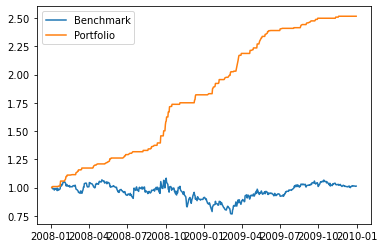

In [37]:
#run whole code
dates = get_trading_dates(dt.datetime(2010, 12, 1), dt.datetime(2012, 1, 1))
prices=get_data(['JPM'], dates, 'Adj Close')
plot_strategy()